In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import os
import ntpath

### Compare tf y_hat and torch y_hat of that of ground truth

In [3]:
# Read in JSON file

def get_yhat(id, seed):

    #torch_id = "Pytorch_RP_fig2_rep_4thattempt_f02aaf8dd647d900a537b6595fc16d92"
    #torch_id = "Pytorch_RP_fig2_rep_5thattempt_18b9f662238ffa48b9457ee6d5b5f90f"
    #tf_id = "Tensorflow_RP_fig2_rep_3db3abf024fd02760dedd90c6b3cbae9"

    base_path = "/data/weirauchlab/team/ngun7t/cellbox_results/results"
    with open(f"{base_path}/{id}/config.json", "rb") as f:
        d = json.load(f)

    # Read in the y_hat csv file of the last stage
    y_hat = pd.read_csv(glob.glob(f"{base_path}/{id}/seed_{seed}/6_best.y_hat.loss.*.csv")[0])
    y_hat = y_hat.drop("Unnamed: 0", axis=1)

    # Read in the ground truth perturbation result
    y_true = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv", header=None).to_numpy()

    # Read in random_pos.csv
    random_pos = pd.read_csv(f"{base_path}/{id}/seed_{seed}/random_pos.csv", header=None)[0].values

    trainset_ratio, validset_ratio = d["trainset_ratio"], d["validset_ratio"]
    nvalid = int(y_true.shape[0] * trainset_ratio)
    ntrain = int(nvalid * validset_ratio)

    print(ntrain)
    print(nvalid)
    print(len(random_pos) - nvalid) 
    print(y_hat.shape[0])

    # Get those indices for test conditions
    test_indices = random_pos[nvalid:]

    # Get ground truth test expression
    y_true_test = y_true[test_indices]

    # Compare this with y_hat 
    y_hat_test = y_hat.to_numpy()

    return y_hat_test, y_true_test

seed = "001"
torch_id = "Pytorch_RP_fig2_rep_5thattempt_18b9f662238ffa48b9457ee6d5b5f90f"
tf_id = "Tensorflow_RP_fig2_rep_3db3abf024fd02760dedd90c6b3cbae9"
torch_clean_id = "Pytorch_RP_fig2_rep_1stattempt_cleancode_1d9ac76d6ecf4a536c8a91405734f9d8"
y_hat_tf, y_true_test = get_yhat(tf_id, seed)
y_hat_torch, y_true_test = get_yhat(torch_id, seed)
y_hat_clean, y_true_test = get_yhat(torch_clean_id, seed)

49
62
27
27
49
62
27
27
49
62
27
27


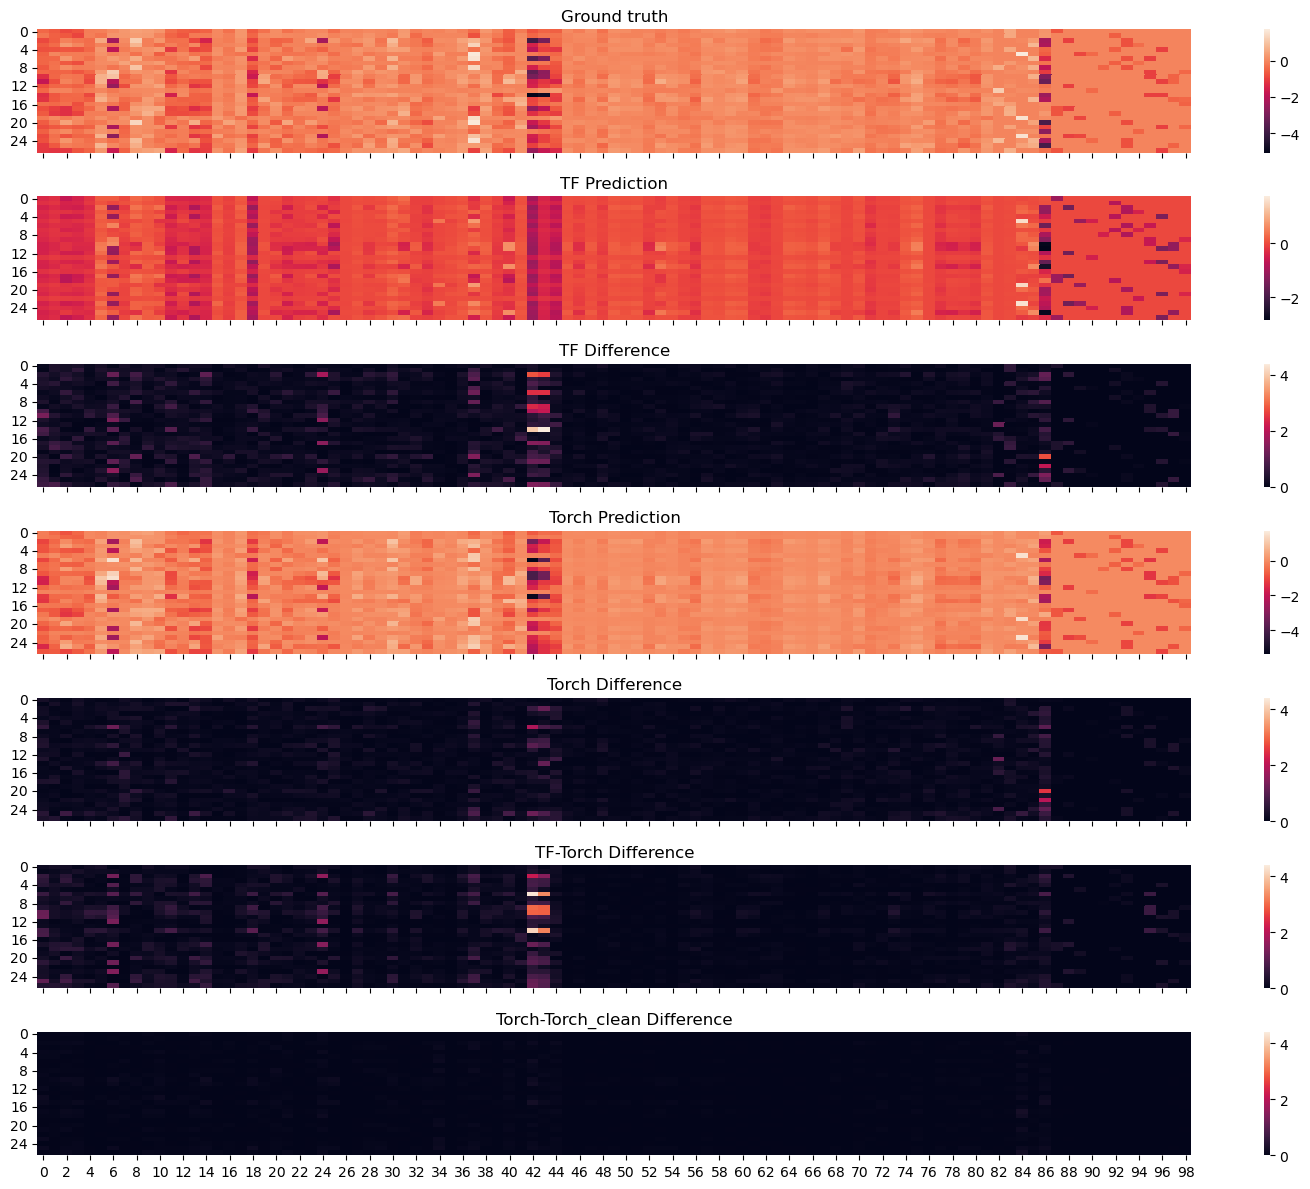

In [5]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 12), sharex=True)

max_val = max([np.amax(y_true_test), np.amax(y_hat_tf), np.amax(y_hat_torch)])
max_diff = max([
    np.amax(np.abs(y_hat_tf - y_true_test)),
    np.amax(np.abs(y_hat_torch - y_true_test)),
    np.amax(np.abs(y_hat_tf - y_hat_torch))
])

sns.heatmap(y_true_test, ax=axes[0], vmax=max_val)
axes[0].set_title("Ground truth")
sns.heatmap(y_hat_tf, ax=axes[1], vmax=max_val)
axes[1].set_title("TF Prediction")
sns.heatmap(np.abs(y_hat_tf - y_true_test), ax=axes[2], vmax=max_diff)
axes[2].set_title("TF Difference")
sns.heatmap(y_hat_torch, ax=axes[3], vmax=max_val)
axes[3].set_title("Torch Prediction")
sns.heatmap(np.abs(y_hat_torch - y_true_test), ax=axes[4], vmax=max_diff)
axes[4].set_title("Torch Difference")
sns.heatmap(np.abs(y_hat_tf - y_hat_torch), ax=axes[5], vmax=max_diff)
axes[5].set_title("TF-Torch Difference")
sns.heatmap(np.abs(y_hat_clean - y_hat_torch), ax=axes[6], vmax=max_diff)
axes[6].set_title("Torch-Torch_clean Difference")
plt.tight_layout()
plt.show()

In [ ]:
# Make a manual prediction


### Integrate information from the 500 trained models and see if we can replicate Figure 2 of the paper

Challenge: has to filter out oscillatory solutions

In [2]:
# Read in the ground truth perturbation result
y_true = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv", header=None).to_numpy()

base_dir = "/data/weirauchlab/team/ngun7t/cellbox_results/results/Pytorch_RP_fig2_rep_5thattempt_18b9f662238ffa48b9457ee6d5b5f90f"
with open(f"{base_dir}/config.json", "rb") as f:
    d = json.load(f)

experiments = glob.glob(os.path.join(base_dir, "seed_*"))
trainset_ratio, validset_ratio = d["trainset_ratio"], d["validset_ratio"]
nvalid = int(y_true.shape[0] * trainset_ratio)
ntrain = int(nvalid * validset_ratio)

expr_results = []

for experiment in experiments:

    # Create an empty numpy array
    expr_result = np.zeros(y_true.shape)

    # Read in random_pos.csv
    random_pos = pd.read_csv(f"{experiment}/random_pos.csv", header=None)[0].values
    test_indices = random_pos[nvalid:]

    # Read in the prediction
    expr_last_stage_dir = glob.glob(f"{experiment}/6_best.y_hat.loss*")
    if len(expr_last_stage_dir) != 0:
        y_hat = pd.read_csv(expr_last_stage_dir[0])
        y_hat = y_hat.drop("Unnamed: 0", axis=1)

        # Add the new result to the empty array
        expr_result[test_indices] = y_hat.to_numpy()
        # A very random cutoff
        #if np.amax(expr_result) > 3 or np.amin(expr_result) < -6: continue
        #else: expr_results.append(expr_result)
        expr_results.append(expr_result)
    else:
        print(f"Experiment {ntpath.basename(experiment)} did not finish")

result_arr = np.stack(expr_results, axis=0) # shape = (500, 89, 99)

In [3]:
counts = 0
for i in range(result_arr.shape[0]):
    slice = result_arr[i]
    #print(f"Max val: {np.amax(slice)}, min val: {np.amin(slice)}")
    if np.amax(slice) > 3 or np.amin(slice < -6):
        counts += 1
        print(f"Slice {i} has max val: {np.amax(slice)} at {np.unravel_index(np.argmax(slice), slice.shape)}, min val: {np.amin(slice)}")

In [4]:
nonzero_counts = np.repeat(np.expand_dims(np.sum(np.any(result_arr != 0, axis=2), axis=0), axis=1), repeats=99, axis=-1)
sum_across_experiments = np.sum(result_arr, axis=0)
result_arr_average = sum_across_experiments / nonzero_counts

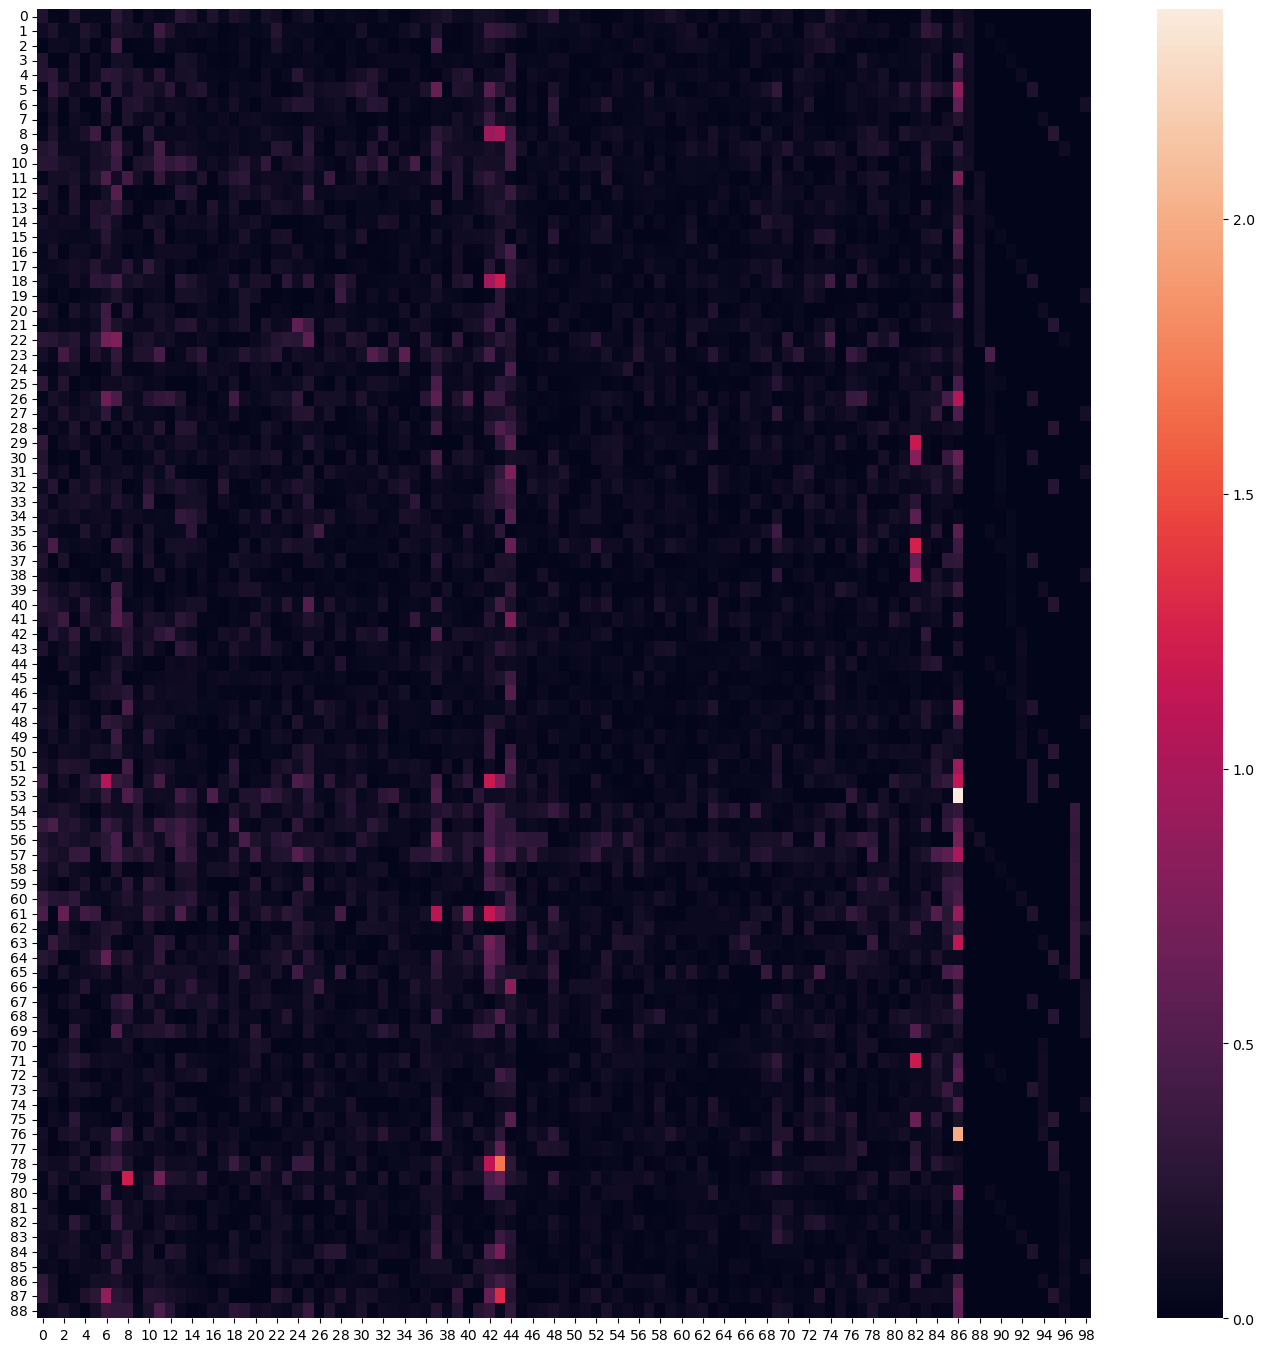

In [6]:
plt.figure(figsize=(17, 17))
sns.heatmap(np.abs(result_arr_average - y_true), vmax=np.amax(np.abs(result_arr_average - y_true)))
plt.show()

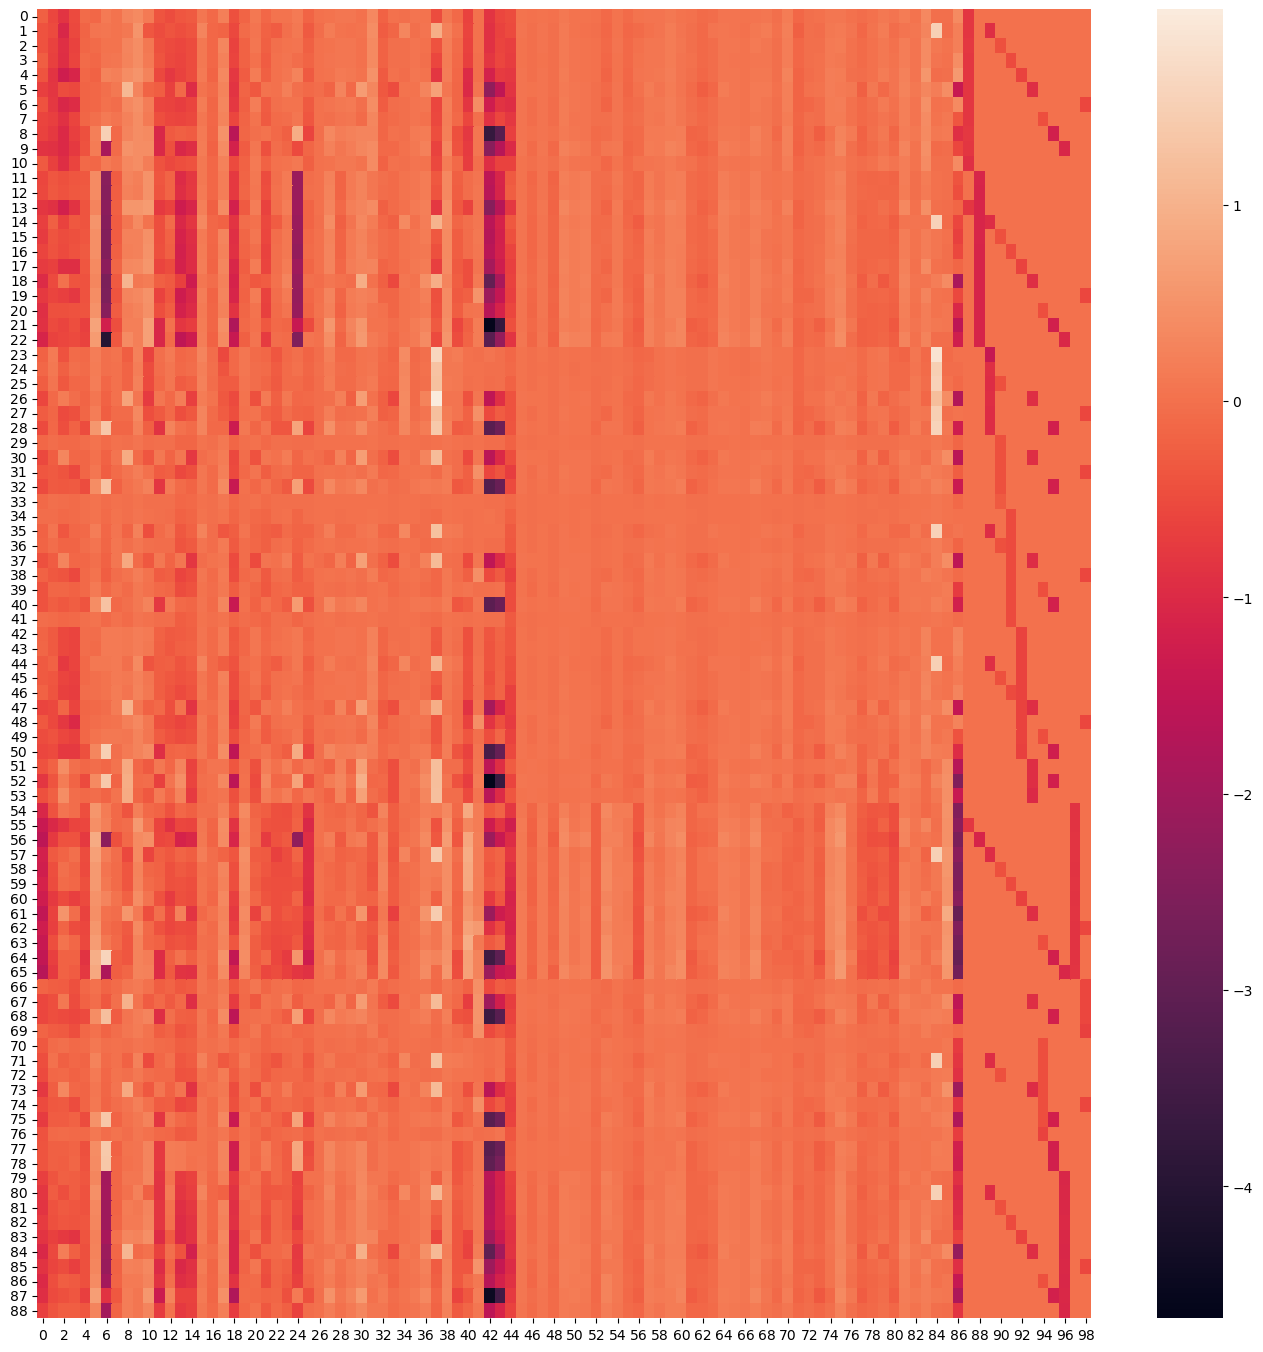

In [5]:
# The model prediction itself
plt.figure(figsize=(17, 17))
sns.heatmap(result_arr_average)
plt.show()

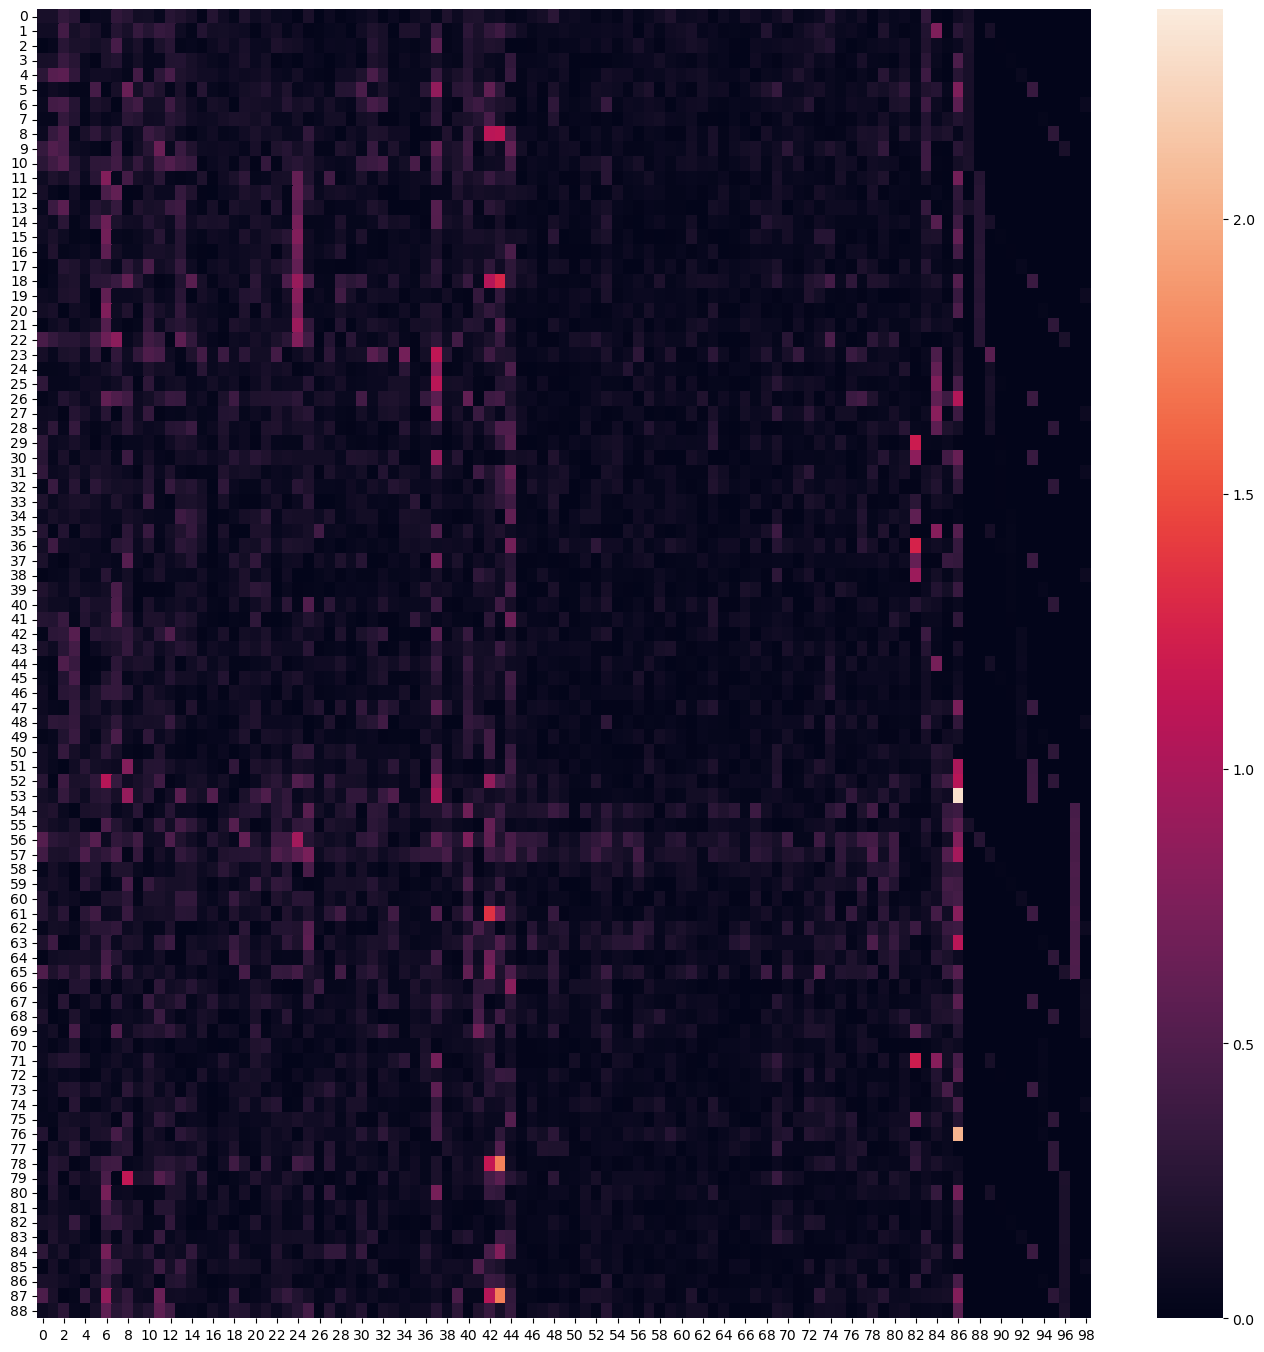

In [7]:
# Heatmap from the true average file
true_average = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/manuscript/Figure2/random_partition_average_testhat_929.csv", index_col=0).to_numpy()
plt.figure(figsize=(17, 17))
sns.heatmap(np.abs(true_average - y_true), vmax=np.amax(np.abs(result_arr_average - y_true)))
plt.show()

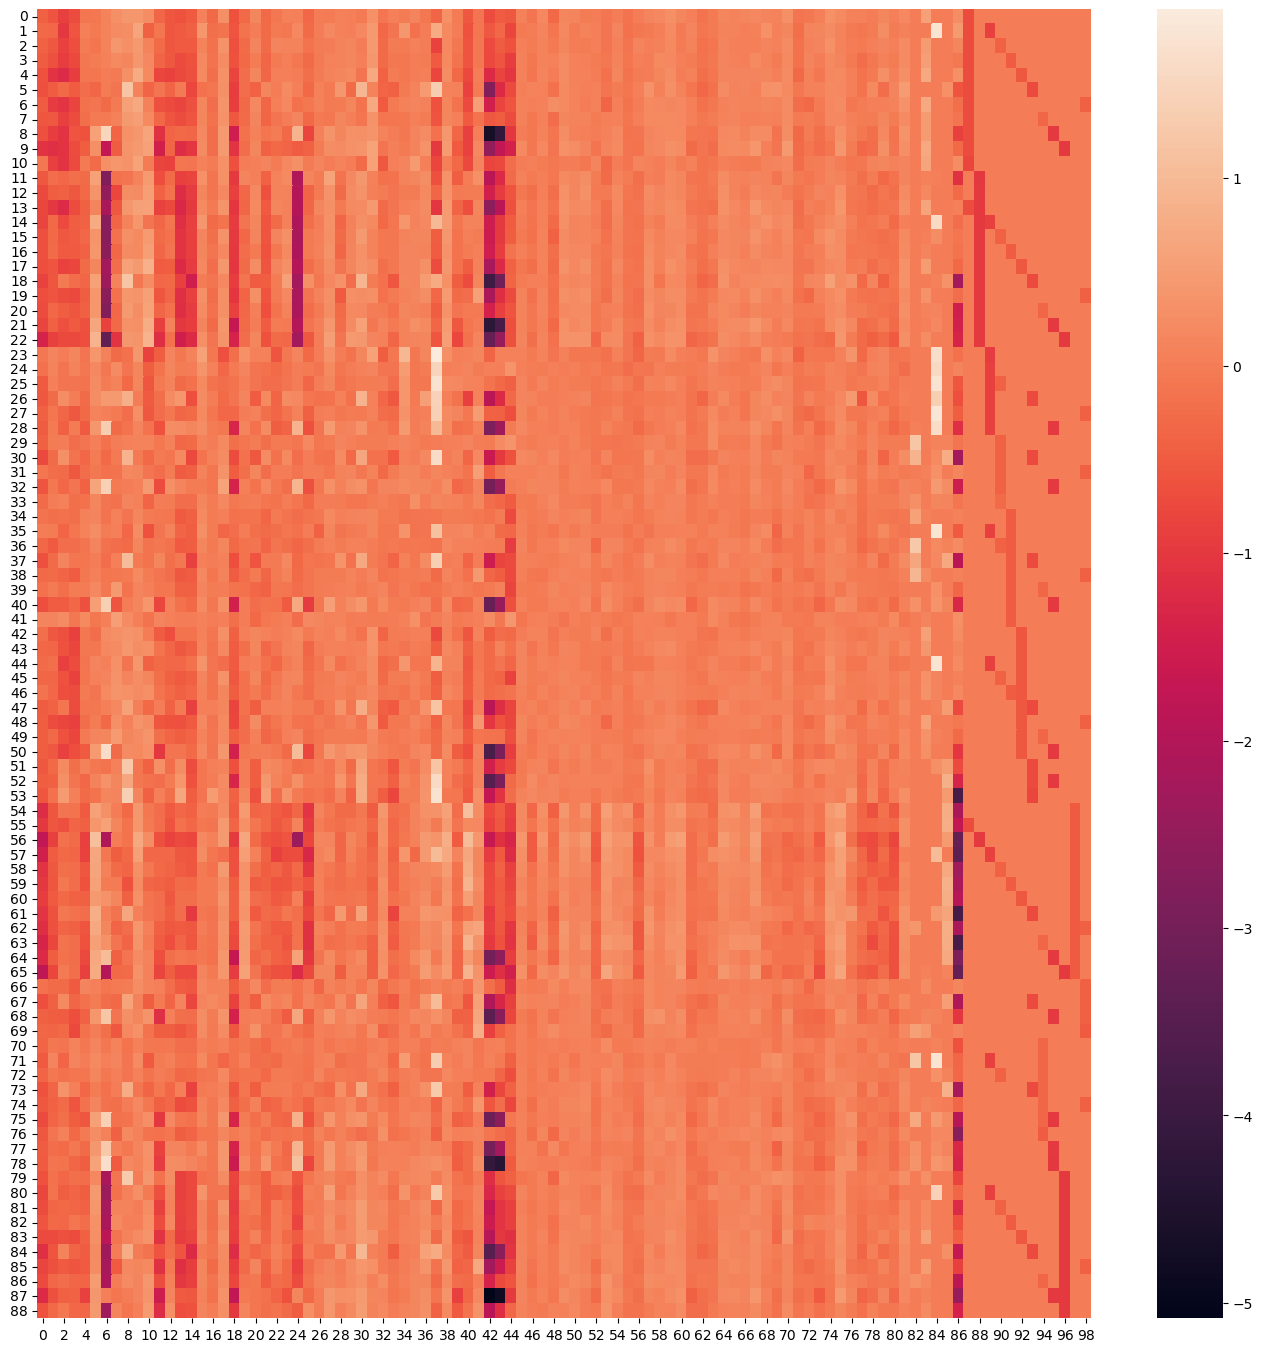

In [31]:
# Heatmap of the true expression
plt.figure(figsize=(17, 17))
sns.heatmap(y_true)
plt.show()

In [73]:
result_average_df = pd.DataFrame(result_arr_average)
result_average_df.to_csv(
    "/users/ngun7t/Documents/cellbox-jun-6/manuscript_rep/Figure2/random_partition_average_pytorch_500_Aug8-23.csv",
)

### Do the same but for tensorflow code

In [14]:
# Read in the ground truth perturbation result
y_true = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv", header=None).to_numpy()

base_dir = "/data/weirauchlab/team/ngun7t/cellbox_results/results/Tensorflow_RP_fig2_rep_3db3abf024fd02760dedd90c6b3cbae9"
with open(f"{base_dir}/config.json", "rb") as f:
    d = json.load(f)

experiments = glob.glob(os.path.join(base_dir, "seed_*"))
trainset_ratio, validset_ratio = d["trainset_ratio"], d["validset_ratio"]
nvalid = int(y_true.shape[0] * trainset_ratio)
ntrain = int(nvalid * validset_ratio)

expr_results = []

for experiment in experiments:

    # Create an empty numpy array
    expr_result = np.zeros(y_true.shape)

    # Read in random_pos.csv
    random_pos = pd.read_csv(f"{experiment}/random_pos.csv", header=None)[0].values
    test_indices = random_pos[nvalid:]

    # Read in the prediction
    expr_last_stage_dir = glob.glob(f"{experiment}/6_best.y_hat.loss*")
    if len(expr_last_stage_dir) != 0:
        y_hat = pd.read_csv(expr_last_stage_dir[0])
        y_hat = y_hat.drop("Unnamed: 0", axis=1)

        # Add the new result to the empty array
        expr_result[test_indices] = y_hat.to_numpy()
        # A very random cutoff
        #if np.amax(expr_result) > 3 or np.amin(expr_result) < -6: continue
        #else: expr_results.append(expr_result)
        expr_results.append(expr_result)
    else:
        print(f"Experiment {ntpath.basename(experiment)} did not finish")

result_arr_tf = np.stack(expr_results, axis=0) # shape = (500, 89, 99)

In [15]:
#nonzero_counts_tf = np.count_nonzero(result_arr_tf, axis=0)[:, :87]
nonzero_counts_tf = np.repeat(np.expand_dims(np.sum(np.any(result_arr_tf != 0, axis=2), axis=0), axis=1), repeats=99, axis=-1)
sum_across_experiments_tf = np.sum(result_arr_tf, axis=0)
result_arr_average_tf = sum_across_experiments_tf / nonzero_counts_tf

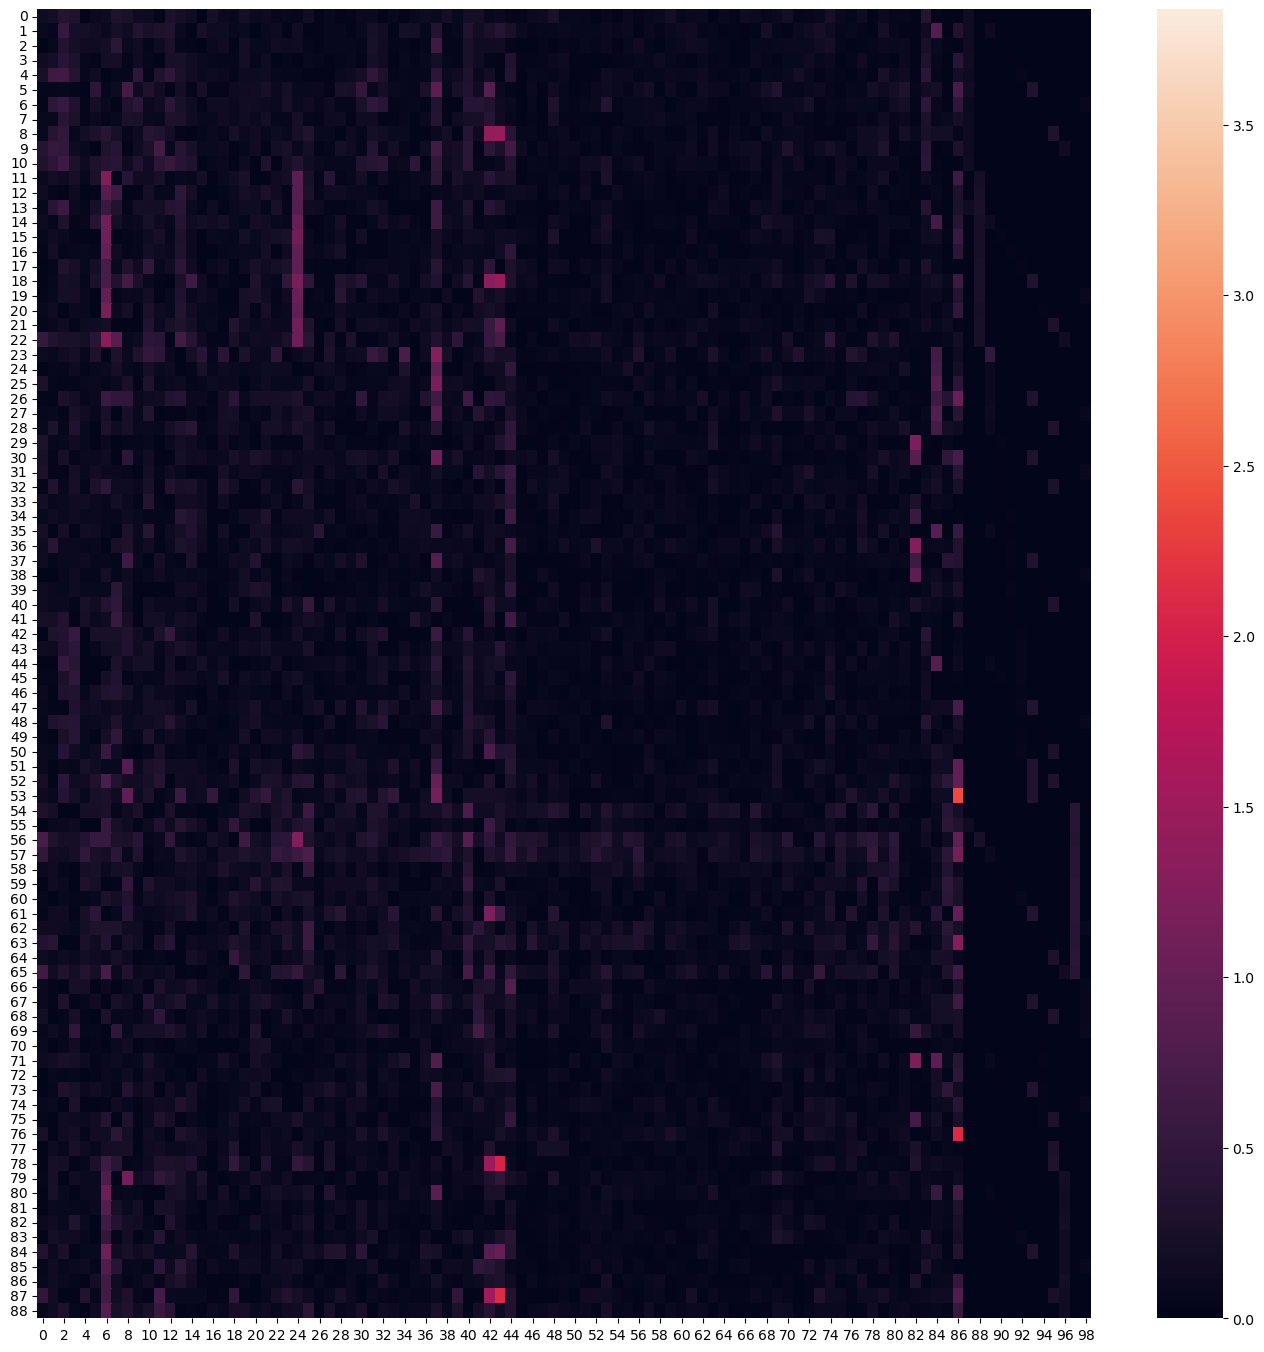

In [16]:
plt.figure(figsize=(17, 17))
sns.heatmap(np.abs(result_arr_average_tf - y_true), vmax=3.838)
plt.show()

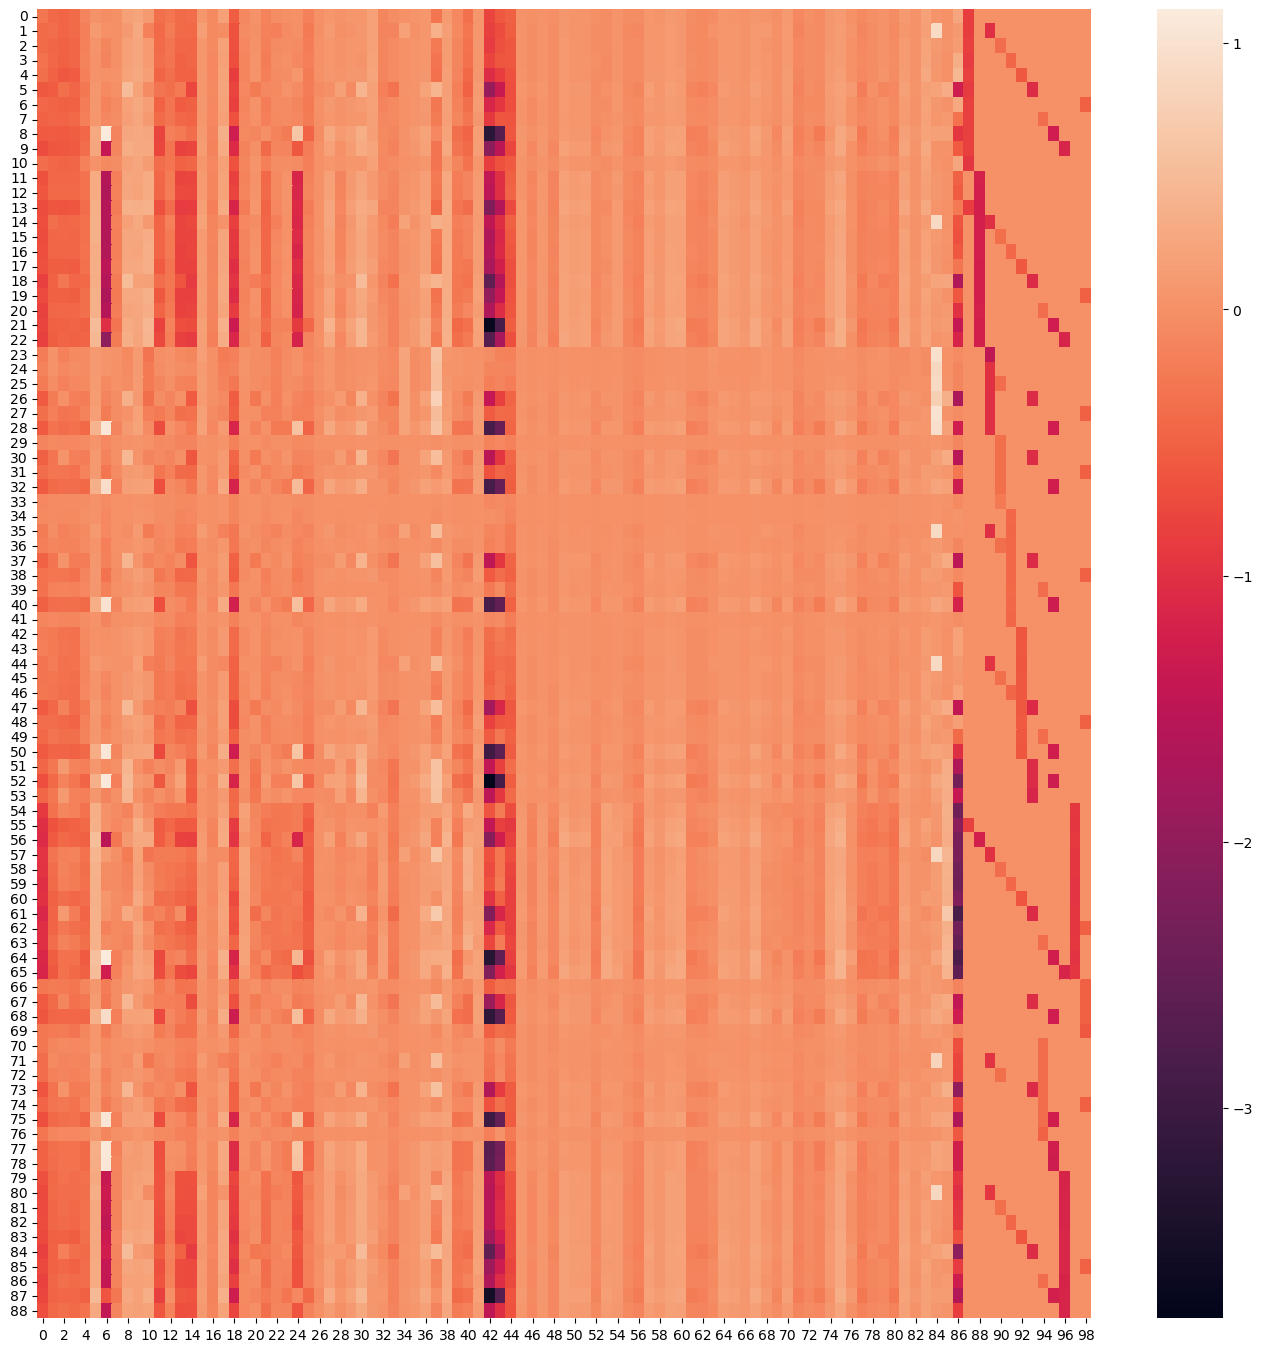

In [29]:
plt.figure(figsize=(17, 17))
sns.heatmap(result_arr_average_tf)
plt.show()

### Test seed

In [18]:
import glob

In [9]:
tf_random_seed_paths = glob.glob("/data/weirauchlab/team/ngun7t/cellbox_results/results/Tensorflow_RP_fig2_rep_3db3abf024fd02760dedd90c6b3cbae9/*/random_pos.csv")
indices_tf = []
for p in tf_random_seed_paths:
    indices_tf.append(pd.read_csv(p).to_numpy())

torch_random_seed_paths = glob.glob("/data/weirauchlab/team/ngun7t/cellbox_results/results/Pytorch_RP_fig2_rep_4thattempt_f02aaf8dd647d900a537b6595fc16d92/*/random_pos.csv")
indices_torch = []
for p in torch_random_seed_paths:
    indices_torch.append(pd.read_csv(p).to_numpy())


In [14]:
i = -1
for tf_ind, torch_ind in zip(indices_tf, indices_torch):
    i += 1
    if not np.all(tf_ind == torch_ind):
        print(f"Seed {i} is different")

### Test if tensorflow and pytorch has the same 0 values

In [24]:
tf_paths = glob.glob("/data/weirauchlab/team/ngun7t/cellbox_results/results/Tensorflow_RP_fig2_rep_3db3abf024fd02760dedd90c6b3cbae9/*/6_best.y_hat*")
tf_preds = []
for p in tf_paths:
    df = pd.read_csv(p)
    df = df.drop("Unnamed: 0", axis=1)
    tf_preds.append(df.to_numpy())

torch_paths = glob.glob("/data/weirauchlab/team/ngun7t/cellbox_results/results/Pytorch_RP_fig2_rep_4thattempt_f02aaf8dd647d900a537b6595fc16d92/*/6_best.y_hat*")
torch_preds = []
for p in torch_paths:
    df = pd.read_csv(p)
    df = df.drop("Unnamed: 0", axis=1)
    torch_preds.append(df.to_numpy())

In [35]:
tf_preds[2][1, 87:]

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.46867502,
        0.        ,  0.        ,  0.        ,  0.        , -1.375284  ,
        0.        ,  0.        ])

In [23]:
tf_preds[0].shape

(27, 100)

In [ ]:
def check_similar_0s(arr1, arr2):
    pass
    

### Visualize loss distribution for each model

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import ntpath

In [40]:
tf_paths = glob.glob("/data/weirauchlab/team/ngun7t/cellbox_results/results/Tensorflow_RP_fig2_rep_3db3abf024fd02760dedd90c6b3cbae9/*/6_best.y_hat*")
tf_loss = []
for p in tf_paths:
    tf_loss.append(
        float(".".join(ntpath.basename(p).split(".")[-3:-1]))
    )
max_val = np.amax(np.array(tf_loss))
tf_loss.remove(max_val)

torch_paths = glob.glob("/data/weirauchlab/team/ngun7t/cellbox_results/results/Pytorch_RP_fig2_rep_4thattempt_f02aaf8dd647d900a537b6595fc16d92/*/6_best.y_hat*")
torch_loss = []
for p in torch_paths:
    torch_loss.append(
        float(".".join(ntpath.basename(p).split(".")[-3:-1]))
    )

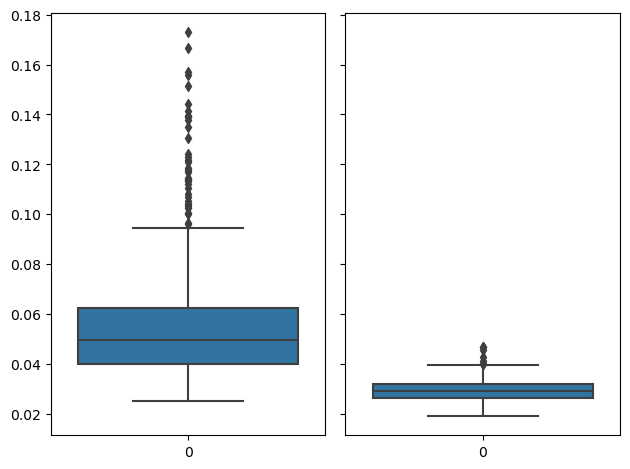

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
sns.boxplot(data=tf_loss, ax=axes[0])
sns.boxplot(data=torch_loss, ax=axes[1])
plt.tight_layout()